# Deep Learning with fashionMNIST

Since I have been studying the theory behind Deepl Learning and Neural Networks for several weeks now, it was time for me to get some hands-on experience One of the classic beginner projects is MNIST dataset containing pictures of hadnwritten digits. However, I was not very excited about this dataset, given how many examples and notebooks I have already seen using it. So I decided to change it up a little bit and use fashionMNIST, a dataset of article images on Zalando. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image and belongs to one of 10 classes. It thus has the exact same properties as the original MNIST dataset.      

In [47]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch import nn

from PIL import Image

## Import data

In [66]:
mnist_train = datasets.FashionMNIST('./fashionmnist', download=True, train=True)
mnist_test = datasets.FashionMNIST('./fashionmnist_test', download=True, train=False)

In [67]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [69]:
training_features = mnist_train.data
training_labels = mnist_train.targets

test_features = mnist_test.data
test_labels = mnist_test.targets

In [70]:
train_features, valid_features, train_labels, valid_labels = train_test_split(training_features, training_labels, test_size=0.2, random_state=42)

## Build the datasets and dataloaders

My fasionMNISTDataset class build on top of the torch.utils.data.Dataset class and includes the option to display the image when calling its index by setting `plot=True`.

In [24]:
class fashionMNISTDataset(Dataset):
    
    def __init__(self, features, labels, plot=True):
        self.images = features
        self.labels = labels
        self.plot = plot
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        image = self.images[idx, :]
        label = self.labels[idx]
        #sample = {'image': image, 'label': label}
        sample = (image, label)
        if self.plot:
            plt.imshow(self.images[idx].reshape(28, 28), cmap='gray')
            plt.title(get_label(self.labels[idx]))
        return sample

In [25]:
def get_label(label):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[i] for i in label]

In [26]:
get_label([1,2,3])

['trouser', 'pullover', 'dress']

I only build a training and test dataset, not a validation dataset, since I will give my `train` function (see below) `valid_feature` and `valid_labels` directly.

In [71]:
train_ds = fashionMNISTDataset(train_features, train_labels, plot=False)
test_ds = fashionMNISTDataset(test_features, test_labels, plot=False)

With the datasets I can now build a dataloader for both the training set and the test set.

In [73]:
batch_size = 50

train_dl = data.DataLoader(train_ds, batch_size=batch_size)
test_dl = data.DataLoader(test_ds, batch_size = batch_size)

In order to be able to see the images of a batch, I build the function `show_image` and test it on the first batch in the dataloader.

In [30]:
def show_images(images, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * 1.5, num_rows * 1.5)
    figure, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    figure.tight_layout()
    for i, (ax, images) in enumerate(zip(axes, images)):
        ax.imshow(np.array(images), cmap='gray')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [31]:
X, y = next(iter(train_dl))

In [32]:
X.shape, y.shape

(torch.Size([50, 28, 28]), torch.Size([50]))

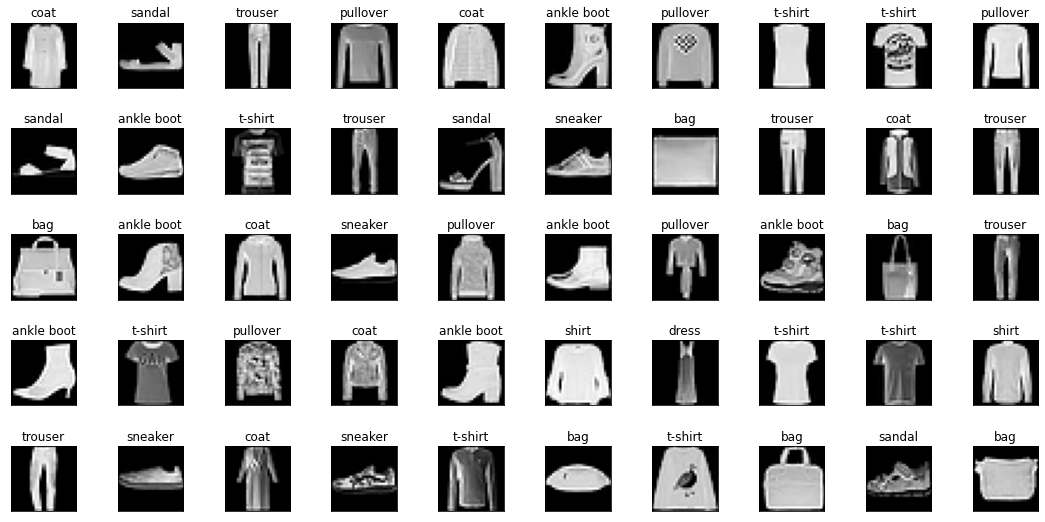

In [33]:
show_images(X.reshape(batch_size, 28,28), 5, 10, titles=get_label(y));

## Building the model

The model serving as my baseline is a simple two fully connected layers using the `nn.Module` class in PyTorch.

In [137]:
class NN(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
        nn.Linear(in_dim, hidden_dim), 
        nn.ReLU(),
        nn.Linear(hidden_dim, out_dim))
        
    def forward(self, X):
        return self.net(X)

I then build a `train` function that performs forward and backward propagation and also plots the learning curve.

In [145]:
def train(train_dl, valid_features, valid_labels, num_epochs, learning_rate, weight_decay, batch_size, device):
    
    import pdb; pdb.set_trace()
    
    #net = NN_1(in_dim, hidden_dim, out_dim)
    torch.manual_seed(42)
    train_loss, valid_loss = [], []
    optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
    for epoch in range(num_epochs):  
        for batch in train_dl:
            X, y = batch[0], batch[1]
            optimizer.zero_grad()
            X = X.reshape(batch_size, in_dim)
            preds = net(X)
            l = loss(preds, y)
            l.backward()
            optimizer.step()
        train_loss.append(loss(net(X), y).detach())
        if valid_features is not None:
            valid_loss.append(loss(net(valid_features), valid_labels).detach())
    
    train_loss = torch.stack(train_loss)
    valid_loss = torch.stack(valid_loss)
    
    plot_learning_curve(num_epochs, train_loss, valid_loss);
    
    return preds, train_loss, valid_loss     

In [133]:
def plot_learning_curve(num_epochs, train_loss, valid_loss):
    plt.plot(range(num_epochs), train_loss.numpy(), label='train loss')
    plt.plot(range(num_epochs), valid_loss.numpy(), label='valid loss')
    plt.xticks(range(num_epochs), range(1, num_epochs + 1))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()

In [131]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.normal_(m.weight, std=0.01)

I use cross-entropy loss as the loss function for this model since the task at hand is a multilabel classification problem.

In [132]:
loss = nn.CrossEntropyLoss()

## Training

In [134]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
device

device(type='cuda', index=0)

In [135]:
in_dim, hidden_dim, out_dim = 784, 100, 10

In [144]:
net = NN(in_dim, hidden_dim, out_dim)
for p in net.parameters():
  print(p.shape)

torch.Size([100, 784])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])


In [146]:
num_epochs = 3
learning_rate = 0.3
weight_decay = 0

net = NN(in_dim, hidden_dim, out_dim)
net.apply(init_weights)
net.to(device)
print(net)

preds, train_loss, valid_loss = train( 
                                      valid_features=valid_features, 
                                      valid_labels=valid_labels, 
                                      train_dl=train_dl, 
                                      num_epochs=num_epochs, 
                                      learning_rate=learning_rate, 
                                      weight_decay=weight_decay, 
                                      batch_size=batch_size, 
                                      device=device
                                      )

NN(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
> <ipython-input-145-cba08cf14691>(6)train()
-> torch.manual_seed(42)
(Pdb) n
> <ipython-input-145-cba08cf14691>(7)train()
-> train_loss, valid_loss = [], []
(Pdb) n
> <ipython-input-145-cba08cf14691>(8)train()
-> optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
(Pdb) n
> <ipython-input-145-cba08cf14691>(10)train()
-> for epoch in range(num_epochs):
(Pdb) n
> <ipython-input-145-cba08cf14691>(11)train()
-> for batch in train_dl:
(Pdb) n
> <ipython-input-145-cba08cf14691>(12)train()
-> X, y = batch[0], batch[1]
(Pdb) n
> <ipython-input-145-cba08cf14691>(13)train()
-> optimizer.zero_grad()
(Pdb) n
> <ipython-input-145-cba08cf14691>(14)train()
-> X = X.reshape(batch_size, in_dim)
(Pdb) n
> <ipython-input-145-cba08cf14691>(15)train()
-> preds = net(X)
(Pdb) n
RuntimeError: expected 

BdbQuit: ignored

## Interpretation

In [65]:
# confusion matrix

def fn_confusion_matrix(y, preds):
    y_arr = y.numpy()
    preds_arr = preds.detach().numpy()
    preds_arr_idx = np.argmax(preds_arr, axis=1)
    
    cm = confusion_matrix(y_arr, preds_arr_idx)
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    df_cm = pd.DataFrame(cm, 
                     index=[i for i in text_labels], 
                     columns = [i for i in text_labels])
    
    return sn.heatmap(df_cm, annot=True, cmap='Reds')

In [ ]:
fn_confusion_matrix(y, preds);